In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
# import LogNorm
from matplotlib.colors import LogNorm


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [2]:
from events_data import events_from_scdinfo
from tst_info import TSTInfo
from debiasing import get_bias_fn, get_histograms
from plots import hist_events_by_labels
import tqdm

def piecewise_linear(x_knots, y_knots):
    def piecewise_linear_inner(x):
        return np.interp(x, x_knots, y_knots)
    return piecewise_linear_inner

def draw_routine(hashes, rw_methods=["CR"], debias_list=[None, "all", "binwise"], calibration_nbin=8, 
                 test_nbin=10):
    assert all(debias in [None, "all", "binwise"] for debias in debias_list)
    device = torch.device("cuda")
    for tstinfo_hash in tqdm.tqdm(hashes):
        tstinfo = TSTInfo.load(tstinfo_hash)
        signal_filename = tstinfo.hparams["signal_filename"]
        seed = tstinfo.hparams["seed"]
        signal_ratio = tstinfo.hparams["signal_ratio"]

        scdinfo_tst = tstinfo.scdinfo_tst
        events_tst = events_from_scdinfo(
            scdinfo_tst, features, signal_filename)

        base_fvt_hash = tstinfo.base_fvt_tinfo_hash
        fvt_model = FvTClassifier.load_from_checkpoint(
            f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
        fvt_model.to(device)
        fvt_model.freeze()

        CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
        CR_model = FvTClassifier.load_from_checkpoint(
            f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
        CR_model.to(device)
        CR_model.freeze()

        SR_stats = tstinfo.SR_stats
        SR_cut = tstinfo.SR_cut
        CR_cut = tstinfo.CR_cut
        in_SR = SR_stats >= SR_cut
        in_CR = (SR_stats < SR_cut) & (SR_stats >= CR_cut)

        ratio_4b = tstinfo.hparams["ratio_4b"]

        for rw_method in rw_methods:
            if rw_method == "CR":
                probs_4b_est = CR_model.predict(
                    events_tst.X_torch).detach().cpu().numpy()[:, 1]
            else:
                probs_4b_est = fvt_model.predict(
                    events_tst.X_torch).detach().cpu().numpy()[:, 1]

            reweights = ratio_4b * probs_4b_est / \
                ((1 - ratio_4b) * (1 - probs_4b_est))
        
            for debias in debias_list:
                if debias == "all":
                    bias_fn = get_bias_fn(events_tst, probs_4b_est, calibration_nbin)
                    bias_3b_rw = bias_fn(probs_4b_est)
                elif debias == "binwise":
                    bias_3b_rw = np.zeros_like(probs_4b_est)
                    
                    q = np.linspace(0, 1, test_nbin+1)
                    for SR_stats_inner, in_region_inner in zip([SR_stats_CR, SR_stats_SR], [in_CR, in_SR]):
                        region_bins = np.quantile(SR_stats_inner, q)
                        region_bins_idx = np.digitize(SR_stats_inner, region_bins)
                        region_bins_idx = np.clip(region_bins_idx, 1, len(q) - 1)
                        CR_idx = np.where(in_region_inner)[0]
                        
                        for i in np.unique(region_bins_idx):
                            in_this_bin = CR_idx[region_bins_idx == i]
                            probs_4b_est_bin = probs_4b_est[in_this_bin]
                            calibration_bins = np.linspace(np.min(probs_4b_est_bin), 
                                                        np.max(probs_4b_est_bin), 
                                                        calibration_nbin + 1)
                            
                            midpoints = (calibration_bins[1:] + calibration_bins[:-1]) / 2
                            
                            hist_4b, _ = np.histogram(probs_4b_est_bin[events_tst.is_4b[in_this_bin]],
                                                        bins=calibration_bins,
                                                        weights=(events_tst.weights[in_this_bin])[events_tst.is_4b[in_this_bin]])
                            hist_all, _ = np.histogram(probs_4b_est_bin,
                                                        bins=calibration_bins,
                                                        weights=(events_tst.weights[in_this_bin]))
                            mean_probs_4b = hist_4b / hist_all
                            calibration_error = np.nan_to_num(midpoints - mean_probs_4b, nan=0)
                            
                            calibration_error_fn = piecewise_linear(midpoints, calibration_error)
                            bias_3b_rw[in_this_bin] = calibration_error_fn(probs_4b_est_bin) * (1 / (1 - probs_4b_est_bin))**2
                        
                    
                else:
                    bias_3b_rw = np.zeros_like(probs_4b_est)

                events_SR = events_tst[in_SR]
                events_CR = events_tst[in_CR]
                SR_stats_SR = SR_stats[in_SR]
                SR_stats_CR = SR_stats[in_CR]

                events_tst_rw = events_tst.clone()
                # include bias
                events_tst_rw.reweight(
                    np.where(events_tst_rw.is_4b, events_tst_rw.weights, events_tst_rw.weights * (reweights - bias_3b_rw)))
                events_SR_rw = events_tst_rw[in_SR]
                events_CR_rw = events_tst_rw[in_CR]

                fig = plt.figure(figsize=(12, 8))
                fig.suptitle(f"seed={seed}, signal_ratio={signal_ratio}, reweighting={rw_method}, debias={debias}")
                gs = GridSpec(3, 2, figure=fig)

                # bins = np.linspace(np.min(SR_stats_CR), np.max(SR_stats_CR), test_nbin+1)
                q = np.linspace(0, 1, test_nbin+1)
                bins = np.quantile(SR_stats_CR, q)

                ax = fig.add_subplot(gs[0, 0])
                hist_events_by_labels(events_CR_rw, SR_stats_CR, bins=bins, ax=ax)
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_title("CR")
                ax.legend()

                histograms = get_histograms(
                    events_CR, SR_stats_CR, bins, reweights[in_CR])
                hist_3b_rw = histograms["3b_rw"]
                hist_3b_rw_sq = histograms["3b_rw_sq"]
                hist_bg4b = histograms["bg4b"]
                hist_4b = histograms["4b"]
                hist_bias_3b_rw, _ = np.histogram(SR_stats_CR[events_CR.is_3b], bins=bins,
                                                    weights=(events_CR.weights * bias_3b_rw[in_CR])[events_CR.is_3b])

                # debiasing
                hist_3b_rw = hist_3b_rw - hist_bias_3b_rw

                ax = fig.add_subplot(gs[1, 0])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_bg4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err,
                            label="bg4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.97, 1.03))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_bg4b - hist_3b_rw) / \
                    np.sqrt(hist_bg4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("CR bg4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))
                
                ax = fig.add_subplot(gs[2, 0])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_4b / hist_3b_rw, yerr=err,
                            label="4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.97, 1.03))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_4b - hist_3b_rw) / \
                    np.sqrt(hist_4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("CR 4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))

                q = np.linspace(0, 1, test_nbin+1)
                bins = np.quantile(SR_stats_SR, q)

                ax = fig.add_subplot(gs[0, 1])
                hist_events_by_labels(events_SR_rw, SR_stats_SR, bins=bins, ax=ax)
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_title("SR")
                ax.legend()

                histograms = get_histograms(
                    events_SR, SR_stats_SR, bins, reweights[in_SR])
                hist_3b_rw = histograms["3b_rw"]
                hist_3b_rw_sq = histograms["3b_rw_sq"]
                hist_4b = histograms["4b"]
                hist_bg4b = histograms["bg4b"]
                hist_bias_3b_rw, _ = np.histogram(SR_stats_SR[events_SR.is_3b], bins=bins,
                                                    weights=(events_SR.weights * bias_3b_rw[in_SR])[events_SR.is_3b])

                # debiasing
                hist_3b_rw = hist_3b_rw - hist_bias_3b_rw

                ax = fig.add_subplot(gs[1, 1])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_bg4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_bg4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_bg4b / hist_3b_rw, yerr=err,
                            label="bg4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.9, 1.1))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_bg4b - hist_3b_rw) / \
                    np.sqrt(hist_bg4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("SR bg4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))
                
                ax = fig.add_subplot(gs[2, 1])
                midpoints = (bins[1:] + bins[:-1]) / 2
                err = np.sqrt(hist_4b / hist_3b_rw**2 +
                                hist_3b_rw_sq * (hist_4b / hist_3b_rw**2)**2)
                ax.errorbar(midpoints, hist_4b / hist_3b_rw, yerr=err,
                            label="4b / 3b", fmt="o", markersize=3)
                ax.hlines(1, bins[0], bins[-1], color="black", linestyle="--")
                ax.set_xlim((bins[0], bins[-1]))
                ax.set_ylim((0.9, 1.1))
                ymin, ymax = ax.get_ylim()
                ax.vlines(bins, ymin, ymax, color="black",
                            linestyle="--", alpha=0.5)

                ax2 = ax.twinx()
                sigma = (hist_4b - hist_3b_rw) / \
                    np.sqrt(hist_4b + hist_3b_rw_sq)
                ax2.plot(midpoints, sigma, "o-", label="sigma", color="red")
                ax2.set_ylim((-4, 4))
                ax2.set_ylabel("sigma")
                ax2.set_title("SR 4b / 3b. sigma avg: {:.2f}".format(
                    np.sqrt(np.mean(sigma**2))))

                plt.tight_layout()
                plt.show()

In [3]:
def plot_hist_and_ratio(tstinfo: TSTInfo, 
                    x_values: np.ndarray, 
                    events_tst_clone: EventsData, 
                    events_tst_original: EventsData,
                    in_CR: np.ndarray, 
                    in_SR: np.ndarray, 
                    nbins: int = 10,
                    bins_mode: str = "quantile",
                    ylim: tuple[float, float] = (0.5, 1.5), 
                    xlabel: str = None,
                    yscale: str = "linear", 
                    title: str = None, 
                    scale_original: bool = False, 
                    do_bg4b: bool=False):
    assert len(x_values) == len(events_tst_clone)
    
    if bins_mode == "quantile":
        bins_CR = np.quantile(x_values[in_CR], np.linspace(0, 1, nbins))
        bins_SR = np.quantile(x_values[in_SR], np.linspace(0, 1, nbins))
    else:
        bins_CR = np.linspace(np.min(x_values[in_CR]), np.max(x_values[in_CR]), nbins)
        bins_SR = np.linspace(np.min(x_values[in_SR]), np.max(x_values[in_SR]), nbins)
        

    gs = GridSpec(3, 2)
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(title)
    fig.supxlabel(xlabel)
    
    tst_fvt_scores_CR = x_values[in_CR]
    events_tst_clone_CR = events_tst_clone[in_CR]
    events_tst_original_CR = events_tst_original[in_CR]
    
    if not do_bg4b:
        hist_4b_CR, _ = np.histogram(tst_fvt_scores_CR[events_tst_clone_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[events_tst_clone_CR.is_4b])
    else:
        hist_4b_CR = np.histogram(tst_fvt_scores_CR[events_tst_clone_CR.is_bg4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[events_tst_clone_CR.is_bg4b])[0]
    hist_signal_CR, _ = np.histogram(tst_fvt_scores_CR[events_tst_clone_CR.is_signal], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[events_tst_clone_CR.is_signal])
    hist_3b_CR, _ = np.histogram(tst_fvt_scores_CR[~events_tst_clone_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_clone_CR.weights[~events_tst_clone_CR.is_4b])
    hist_3b_CR_original, _ = np.histogram(tst_fvt_scores_CR[~events_tst_clone_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=events_tst_original_CR.weights[~events_tst_original_CR.is_4b])
    reweights = events_tst_clone_CR.weights / events_tst_original_CR.weights
    hist_3b_sq_CR_original, _ = np.histogram(tst_fvt_scores_CR[~events_tst_original_CR.is_4b], 
                                    bins=bins_CR, 
                                    weights=(reweights**2 * events_tst_original_CR.weights)[~events_tst_original_CR.is_4b])
    
    if scale_original:
        hist_3b_CR_original = hist_3b_CR_original * np.sum(hist_4b_CR) / np.sum(hist_3b_CR_original)

        
    
    ax = fig.add_subplot(gs[:2, 0])
    ax.set_title("Control Region")
    ax.stairs(hist_3b_CR, bins_CR, label="Reweighted 3b", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_3b_CR_original, bins_CR, label="3b original", linestyle="--", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_4b_CR, bins_CR, label="4b", color=plt.get_cmap("tab10").colors[1])
    ax.stairs(hist_signal_CR, bins_CR, label="Signal", color=plt.get_cmap("tab10").colors[2])
    ax.errorbar((bins_CR[1:] + bins_CR[:-1]) / 2, 
                hist_4b_CR, 
                yerr=np.sqrt(hist_4b_CR + hist_3b_sq_CR_original), 
                fmt="o", markersize=3, capsize=3, 
                color=plt.get_cmap("tab10").colors[1])
    ax.set_yscale(yscale)
    ax.legend()
    
    ax = fig.add_subplot(gs[2, 0])
    ax.errorbar((bins_CR[1:] + bins_CR[:-1]) / 2, hist_4b_CR / hist_3b_CR, 
                yerr=np.sqrt(hist_4b_CR + hist_3b_sq_CR_original) / hist_3b_CR, 
                fmt="o", markersize=3, label="4b / Reweighted 3b", capsize=3, 
                color=plt.get_cmap("tab10").colors[0])
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0], ylim[1] + 0.1, 0.1))  # Set y ticks from 0.5 to 1.5 with interval 0.1
    ax.set_yticklabels([ylim[0]] + [None] * 4 + [(ylim[0] + ylim[1]) / 2] + [None] * 4 + [ylim[1]])
    
    ax.set_ylabel("True 4b / Modeled 4b")
    ax.hlines(1, bins_CR[0], bins_CR[-1], color="black", linestyle="--")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins_CR[1:-1], ymin, ymax, color="black", linestyle="--", alpha=0.5)
    
    # get histogram of 4b, 3b in SR
    tst_fvt_scores_SR = x_values[in_SR]
    events_tst_clone_SR = events_tst_clone[in_SR]
    events_tst_original_SR = events_tst_original[in_SR]
    
    if not do_bg4b:
        hist_4b_SR, _ = np.histogram(tst_fvt_scores_SR[events_tst_clone_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[events_tst_clone_SR.is_4b])
    else:
        hist_4b_SR, _ = np.histogram(tst_fvt_scores_SR[events_tst_clone_SR.is_bg4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[events_tst_clone_SR.is_bg4b])
        
    hist_3b_SR, _ = np.histogram(tst_fvt_scores_SR[~events_tst_clone_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[~events_tst_clone_SR.is_4b])
    hist_signal_SR, _ = np.histogram(tst_fvt_scores_SR[events_tst_clone_SR.is_signal], 
                                    bins=bins_SR, 
                                    weights=events_tst_clone_SR.weights[events_tst_clone_SR.is_signal])
    hist_3b_SR_original, _ = np.histogram(tst_fvt_scores_SR[~events_tst_clone_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=events_tst_original_SR.weights[~events_tst_original_SR.is_4b])
    reweights = events_tst_clone_SR.weights / events_tst_original_SR.weights
    hist_3b_sq_SR_original, _ = np.histogram(tst_fvt_scores_SR[~events_tst_original_SR.is_4b], 
                                    bins=bins_SR, 
                                    weights=(reweights**2 * events_tst_original_SR.weights)[~events_tst_original_SR.is_4b])
    
    if scale_original:
        hist_3b_SR_original = hist_3b_SR_original * np.sum(hist_4b_SR) / np.sum(hist_3b_SR_original)
    
    ax = fig.add_subplot(gs[:2, 1])
    ax.set_title("Signal Region")
    ax.stairs(hist_3b_SR, bins_SR, label="Reweighted 3b", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_3b_SR_original, bins_SR, label="3b original", linestyle="--", color=plt.get_cmap("tab10").colors[0])
    ax.stairs(hist_4b_SR, bins_SR, label="4b", color=plt.get_cmap("tab10").colors[1])
    ax.stairs(hist_signal_SR, bins_SR, label="Signal", color=plt.get_cmap("tab10").colors[2])
    ax.errorbar((bins_SR[1:] + bins_SR[:-1]) / 2, 
                hist_4b_SR, 
                yerr=np.sqrt(hist_4b_SR + hist_3b_sq_SR_original), 
                fmt="o", markersize=3, capsize=3, 
                color=plt.get_cmap("tab10").colors[1])
    ax.set_yscale(yscale)
    ax.legend()
    
    ax = fig.add_subplot(gs[2, 1])
    ax.errorbar((bins_SR[1:] + bins_SR[:-1]) / 2, hist_4b_SR / hist_3b_SR, 
                yerr=np.sqrt(hist_4b_SR + hist_3b_sq_SR_original) / hist_3b_SR, 
                fmt="o", markersize=3, label="4b / Reweighted 3b", capsize=3, 
                color=plt.get_cmap("tab10").colors[0])
    ax.set_ylim(ylim)
    ax.set_yticks(np.arange(ylim[0], ylim[1] + 0.1, 0.1))  # Set y ticks from 0.5 to 1.5 with interval 0.1
    ax.set_yticklabels([ylim[0]] + [None] * 4 + [(ylim[0] + ylim[1]) / 2] + [None] * 4 + [ylim[1]])
    
    ax.set_ylabel("True 4b / Modeled 4b")
    ax.hlines(1, bins_SR[0], bins_SR[-1], color="black", linestyle="--")
    ymin, ymax = ax.get_ylim()
    ax.vlines(bins_SR[1:-1], ymin, ymax, color="black", linestyle="--", alpha=0.5)
    
    # plt.show()
    # plt.close()

In [4]:
def get_sigma_avg(events: EventsData, hist_values: np.ndarray, bins, reweights: np.ndarray):
    hist_3b, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=events.weights[events.is_3b])
    hist_4b, _ = np.histogram(hist_values[events.is_4b], bins=bins, 
                                weights=events.weights[events.is_4b])
    hist_3b_sq, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=(events.weights * reweights)[events.is_3b])
    sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
    sigma_avg = np.sqrt(np.mean(sigma**2))
    
    return sigma_avg

def plot_reweighted_samples(events_reweighted: EventsData, 
                            events_not_reweighted: EventsData,
                            hist_values: np.ndarray, 
                            fig: plt.Figure):
    gs = GridSpec(2, 2, figure=fig)
    for ax_cnt, quantile in enumerate([True, False]):
        if quantile:
            q = np.linspace(0, 1, 10)
            bins = np.quantile(hist_values, q)
        else:
            bins = np.linspace(np.min(hist_values), np.max(hist_values), 10)

        ax = fig.add_subplot(gs[ax_cnt, 0])
        hist_events_by_labels(events_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("Reweighted")
        ax.legend()
        ax = fig.add_subplot(gs[ax_cnt, 1])
        hist_events_by_labels(events_not_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("NOT Reweighted")
        ax.legend()

In [5]:
from matplotlib.colors import LogNorm

from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from signal_region import get_SR_stats
import itertools

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
[n01:238420] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.n01.3393/jf.0/3559129088/shared_mem_cuda_pool.n01 could be created.
[n01:238420] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
GPU available: True (cuda), used: True
TPU av

Epoch 9: 100%|██████████| 163/163 [00:08<00:00, 19.15it/s, v_num=811, val_loss=0.693, train_loss=0.693]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 163/163 [00:08<00:00, 19.08it/s, v_num=811, val_loss=0.693, train_loss=0.693]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]


Epoch 9: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s, avg_val_loss=0.694]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s, avg_val_loss=0.694]


[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 75/75 [00:04<00:00, 16.43it/s, v_num=812, val_loss=0.693, train_loss=0.693]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 75/75 [00:04<00:00, 16.31it/s, v_num=812, val_loss=0.693, train_loss=0.693]


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


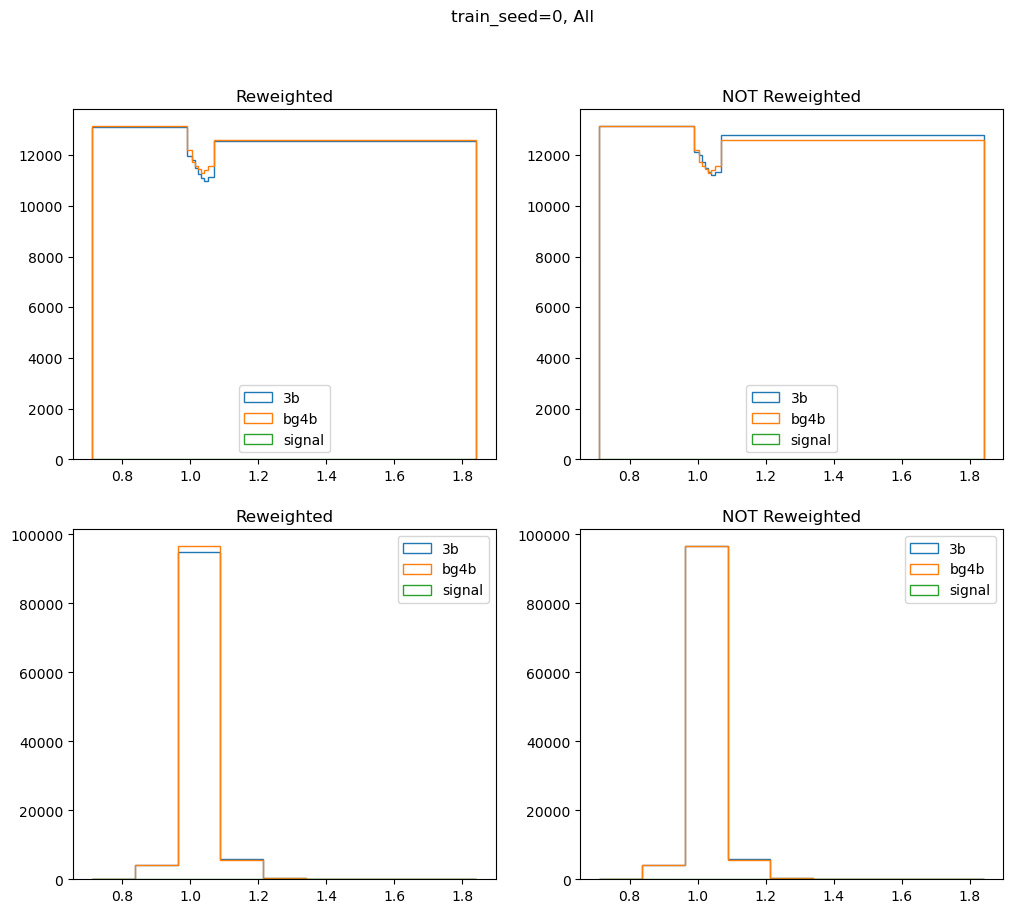

Reweighted / Quantile bins
1.5996985
NOT Reweighted / Quantile bins
1.0839219
Reweighted / Uniform bins
1.4719961
NOT Reweighted / Uniform bins
0.80766946


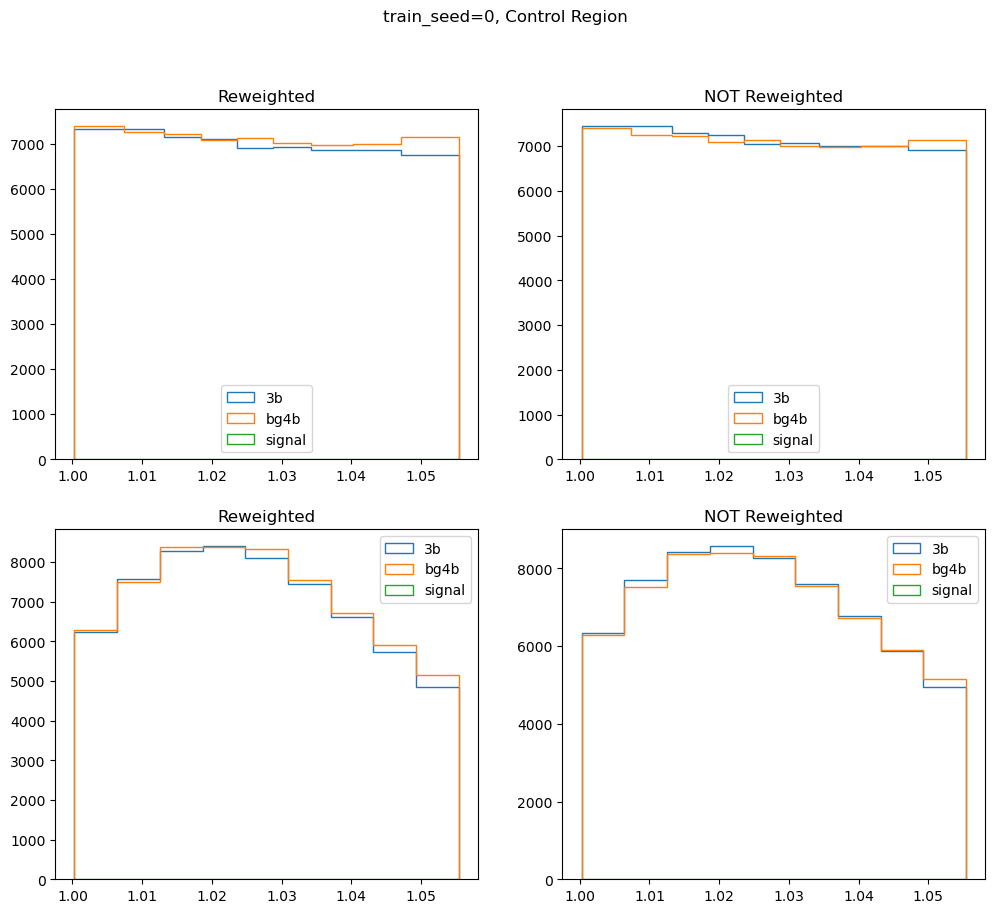

Reweighted / Quantile bins
1.3983831
NOT Reweighted / Quantile bins
1.071246
Reweighted / Uniform bins
1.4333923
NOT Reweighted / Uniform bins
1.0658512


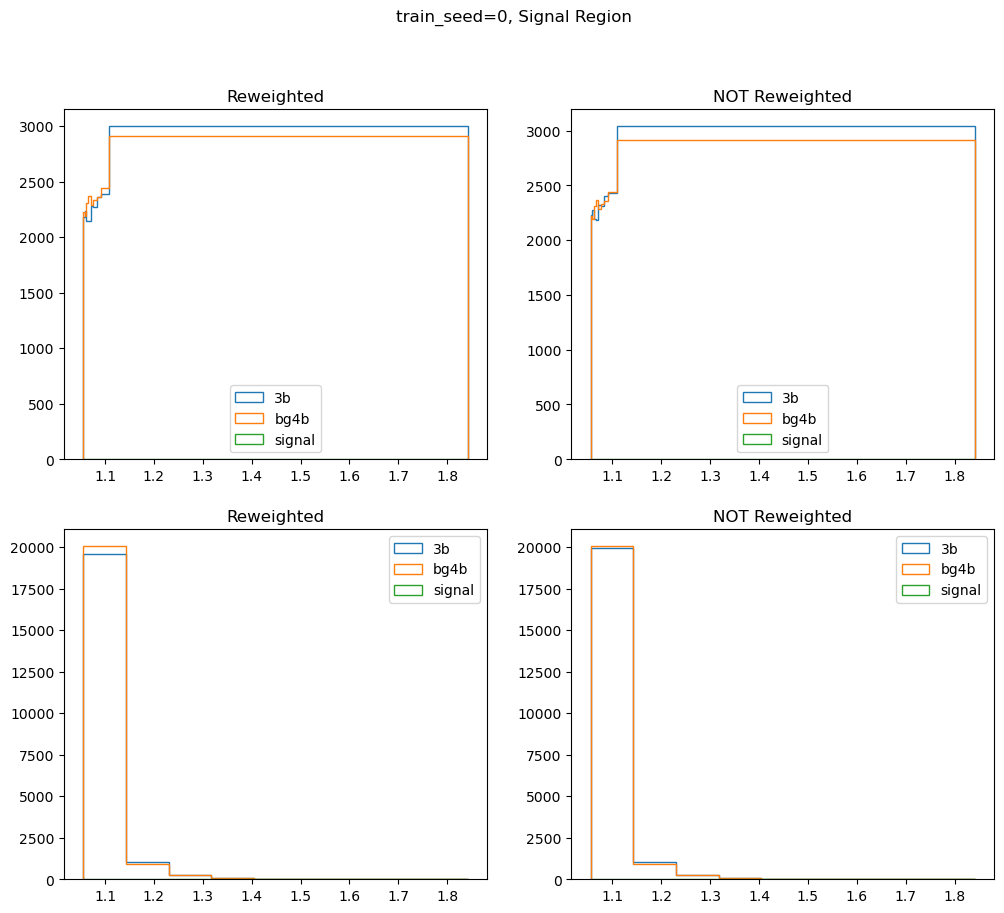

Reweighted / Quantile bins
1.5580679
NOT Reweighted / Quantile bins
1.3988087
Reweighted / Uniform bins
1.5788958
NOT Reweighted / Uniform bins
1.3547496


In [5]:


dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 10,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.5
SR_train_ratio = 0.25

n_3b = 500_000
ratio_4b = 0.5
signal_ratio = 0.0
signal_filename = "HH4b_picoAOD.h5"
data_seed = 0
device = torch.device("cuda")

train_seeds = [0]
nbins = range(1, 11)



# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=data_seed,
)


# Remove 4b events
df_all = df_all.iloc[:n_3b]
assert not df_all["fourTag"].any()
# give random "fourTag" labels
np.random.seed(data_seed)
df_all["fourTag"] = np.random.choice([0, 1], size=n_3b, p=[1 - ratio_4b, ratio_4b])
df_all["signal"] = False

sigma_dicts = []
probs_4b_ests = []
SR_stats = []

for train_seed in train_seeds:

    events_all = EventsData.from_dataframe(df_all, features)
        
    events_train, events_other = events_all.split(base_fvt_train_ratio, seed=data_seed)
    events_SR_train, events_tst = events_other.split(SR_train_ratio, seed=data_seed)
    
    pl.seed_everything(train_seed)
    np.random.seed(train_seed)
    
    base_fvt_hparams["train_seed"] = train_seed
    
    events_train, events_val = events_train.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
    events_train.fit_batch_size(base_fvt_hparams["batch_size"])
    events_val.fit_batch_size(base_fvt_hparams["batch_size"])
    
    base_fvt_train_dset = events_train.to_tensor_dataset()
    base_fvt_val_dset = events_val.to_tensor_dataset()
    
    base_fvt_model = FvTClassifier(
        num_classes,
        dim_input_jet_features,
        base_fvt_hparams["dim_dijet_features"],
        base_fvt_hparams["dim_quadjet_features"],
        run_name="",
        device=torch.device("cuda:0"),
        lr=base_fvt_hparams["lr"],
    )

    base_fvt_model.fit(
        base_fvt_train_dset,
        base_fvt_val_dset,
        batch_size=base_fvt_hparams["batch_size"],
        max_epochs=base_fvt_hparams["max_epochs"],
        train_seed=base_fvt_hparams["train_seed"],
        save_checkpoint=False, 
        callbacks=[],
    )
    base_fvt_model.to(device)
    base_fvt_model.eval()
    
    SR_stat = get_SR_stats(
        events_tst,
        fvt_model=base_fvt_model,
        method="smearing",
        events_SR_train=events_SR_train,
        noise_scale=0.1,
    )
    SR_stats.append(SR_stat)
    
    probs_4b_est = base_fvt_model.predict(events_other.X_torch).detach().cpu().numpy()[:, 1]
    probs_4b_ests.append(probs_4b_est)
    
    SR_stats_argsort = np.argsort(SR_stat)[::-1]
    SR_stats_sorted = SR_stat[SR_stats_argsort]

    weights = events_tst.weights[SR_stats_argsort]
    is_4b = events_tst.is_4b[SR_stats_argsort]
    cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)

    w_4b_SR_ratio = 0.2
    w_4b_CR_ratio = 0.8

    SR_cut, CR_cut = None, None
    for i in range(1, len(cumul_4b_ratio)):
        if cumul_4b_ratio[i] > w_4b_SR_ratio and SR_cut is None:
            SR_cut = SR_stats_sorted[i - 1]
        if cumul_4b_ratio[i] > w_4b_CR_ratio and CR_cut is None:
            CR_cut = SR_stats_sorted[i - 1]
        if SR_cut is not None and CR_cut is not None:
            break

    # If the cut is not found, set the cut to the minimum value
    # Both SR and CR cuts should be different
    if SR_cut is None:
        SR_cut = SR_stats_sorted[-1]
    if CR_cut is None:
        CR_cut = SR_stats_sorted[-1]
    if SR_cut == CR_cut:
        raise ValueError("SR and CR cuts are the same")

    SR_idx = SR_stat >= SR_cut
    events_tst_SR = events_tst[SR_idx]

    CR_idx = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    events_tst_CR = events_tst[CR_idx]
    
    events_CR_train, events_CR_val = events_tst_CR.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
    events_CR_train.fit_batch_size(base_fvt_hparams["batch_size"])
    events_CR_val.fit_batch_size(base_fvt_hparams["batch_size"])
    
    CR_fvt_train_dset = events_CR_train.to_tensor_dataset()
    CR_fvt_val_dset = events_CR_val.to_tensor_dataset()
    
    CR_fvt_model = FvTClassifier(
        num_classes,
        dim_input_jet_features,
        base_fvt_hparams["dim_dijet_features"],
        base_fvt_hparams["dim_quadjet_features"],
        run_name="",
        device=torch.device("cuda:0"),
        lr=base_fvt_hparams["lr"],
    )
    
    CR_fvt_model.fit(
        CR_fvt_train_dset,
        CR_fvt_val_dset,
        batch_size=base_fvt_hparams["batch_size"],
        max_epochs=base_fvt_hparams["max_epochs"],
        train_seed=base_fvt_hparams["train_seed"],
        save_checkpoint=False,
        callbacks=[],
    )
    CR_fvt_model.to(device)
    CR_fvt_model.eval()
    
    probs_4b_est_CR = CR_fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    events_tst_clone = events_tst.clone()
    reweights = probs_4b_est_CR / (1 - probs_4b_est_CR) * (ratio_4b / (1 - ratio_4b))
    events_tst_clone.reweight(
        np.where(events_tst_clone.is_4b, 
                events_tst_clone.weights, 
                events_tst_clone.weights * reweights)
    )
    
    sigma_dict = {}
    
    for nbin, quantile, reweighted, region in itertools.product(nbins, 
                                                                [True, False], 
                                                                [True, False], 
                                                                ["all", "CR", "SR"]):
        
        if region == "all":
            region_idx = np.ones_like(SR_stat, dtype=bool)
        elif region == "CR":
            region_idx = CR_idx
        elif region == "SR":
            region_idx = SR_idx
        else:
            raise ValueError("Invalid region")
        
        if quantile:
            q = np.linspace(0, 1, nbin + 1)
            bins = np.quantile(SR_stat[region_idx], q)
        else:
            bins = np.linspace(np.min(SR_stat[region_idx]), np.max(SR_stat[region_idx]), nbin)
            
        if reweighted:
            sigma_avg = get_sigma_avg(events_tst_clone[region_idx], 
                                        SR_stat[region_idx], 
                                        bins, 
                                        reweights[region_idx])
        else:
            sigma_avg = get_sigma_avg(events_tst[region_idx], 
                                        SR_stat[region_idx], 
                                        bins, 
                                        reweights=1)
    
        sigma_dict[(reweighted, region, quantile, nbin)] = sigma_avg

    sigma_dicts.append(sigma_dict)
        
    
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(f"train_seed={train_seed}, All")
    plot_reweighted_samples(events_tst_clone, events_tst, SR_stat, fig)
    plt.show()
    plt.close()
    print("Reweighted / Quantile bins")
    print(sigma_dict[(True, "all", True, 10)])
    print("NOT Reweighted / Quantile bins")
    print(sigma_dict[(False, "all", True, 10)])
    print("Reweighted / Uniform bins")
    print(sigma_dict[(True, "all", False, 10)])
    print("NOT Reweighted / Uniform bins")
    print(sigma_dict[(False, "all", False, 10)])
    
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(f"train_seed={train_seed}, Control Region")
    plot_reweighted_samples(events_tst_clone[CR_idx], events_tst[CR_idx], SR_stat[CR_idx], fig)
    plt.show()
    plt.close()
    print("Reweighted / Quantile bins")
    print(sigma_dict[(True, "CR", True, 10)])
    print("NOT Reweighted / Quantile bins")
    print(sigma_dict[(False, "CR", True, 10)])
    print("Reweighted / Uniform bins")
    print(sigma_dict[(True, "CR", False, 10)])
    print("NOT Reweighted / Uniform bins")
    print(sigma_dict[(False, "CR", False, 10)])
    
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(f"train_seed={train_seed}, Signal Region")
    plot_reweighted_samples(events_tst_clone[SR_idx], events_tst[SR_idx], SR_stat[SR_idx], fig)
    plt.show()
    plt.close()
    print("Reweighted / Quantile bins")
    print(sigma_dict[(True, "SR", True, 10)])
    print("NOT Reweighted / Quantile bins")
    print(sigma_dict[(False, "SR", True, 10)])
    print("Reweighted / Uniform bins")
    print(sigma_dict[(True, "SR", False, 10)])
    print("NOT Reweighted / Uniform bins")
    print(sigma_dict[(False, "SR", False, 10)])
    
    
probs_4b_est = CR_fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]

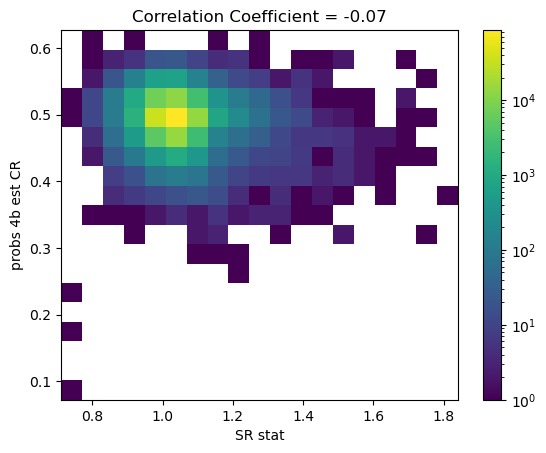

In [6]:
# Set plot parameters
from matplotlib.colors import LogNorm


plt.rcParams["lines.markersize"] = 3

# Define bins for 2D histogram
x_bins = np.linspace(np.min(SR_stat), np.max(SR_stat), 20)
y_bins = np.linspace(np.min(probs_4b_est_CR), np.max(probs_4b_est_CR), 20)

# Create plot
fig, ax = plt.subplots()
im = ax.hist2d(SR_stat, probs_4b_est_CR, bins=[x_bins, y_bins], norm=LogNorm())
fig.colorbar(im[3], ax=ax)

# Set plot labels and title
correlation = np.corrcoef(SR_stat, probs_4b_est_CR)[0, 1]
ax.set_title(f"Correlation Coefficient = {correlation:.2f}")
ax.set_xlabel("SR stat")
ax.set_ylabel("probs 4b est CR")

plt.show()

n_3b=1000000, signal_ratio=0.0, seed=0


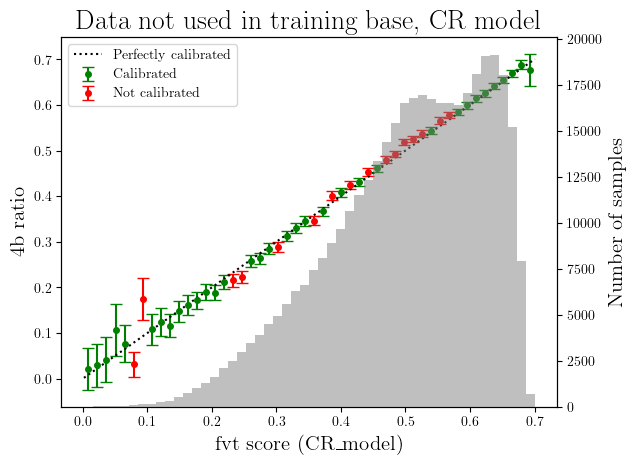

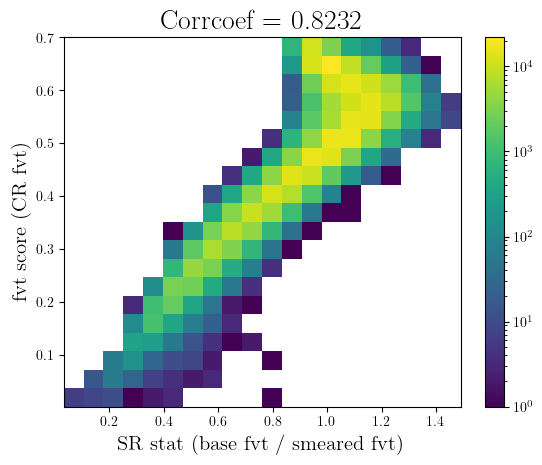

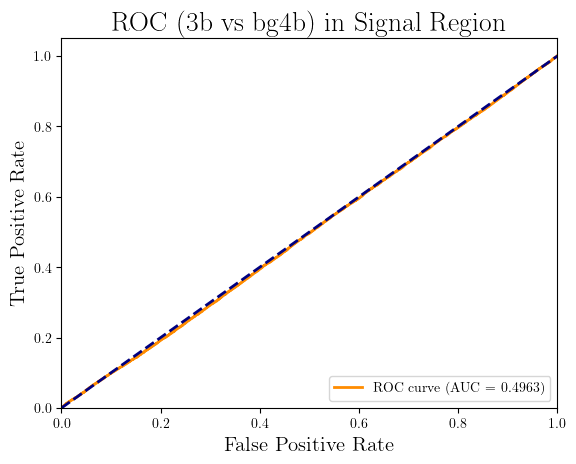

/tmp/ipykernel_1535801/2634567085.py:135: RuntimeWarning: divide by zero encountered in divide
  ax.errorbar((bins_SR[1:] + bins_SR[:-1]) / 2, hist_4b_SR / hist_3b_SR,
/tmp/ipykernel_1535801/2634567085.py:136: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(hist_4b_SR + hist_3b_sq_SR_original) / hist_3b_SR,
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


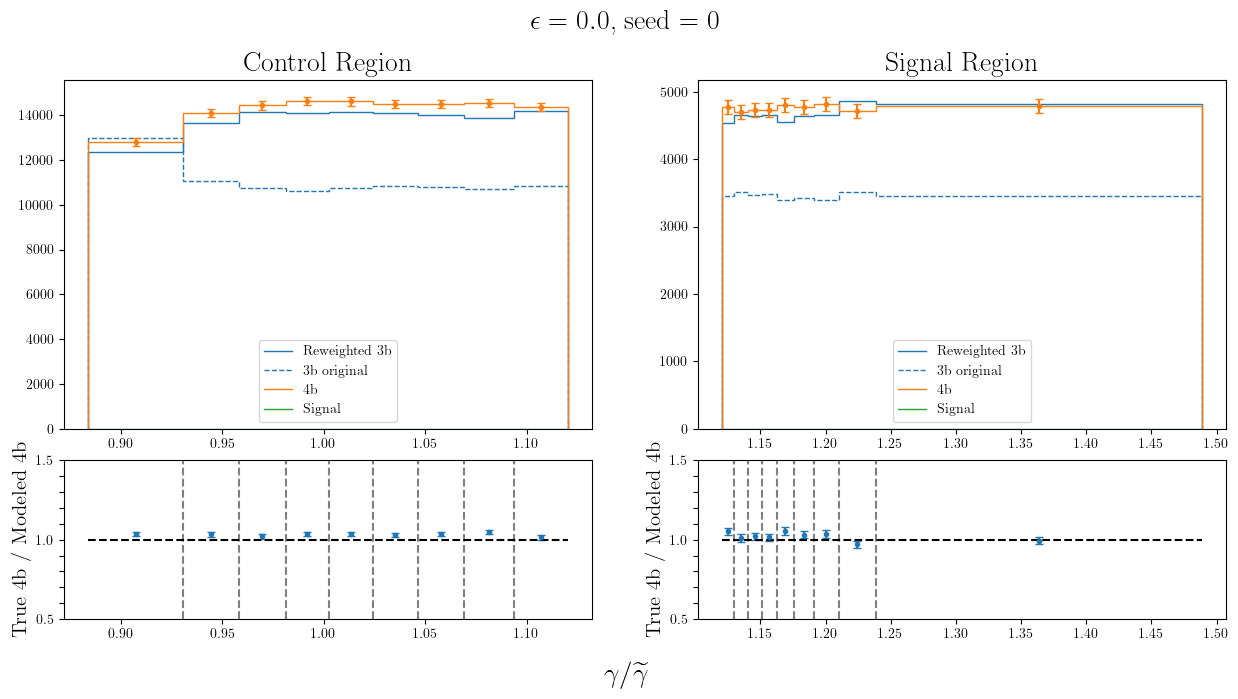

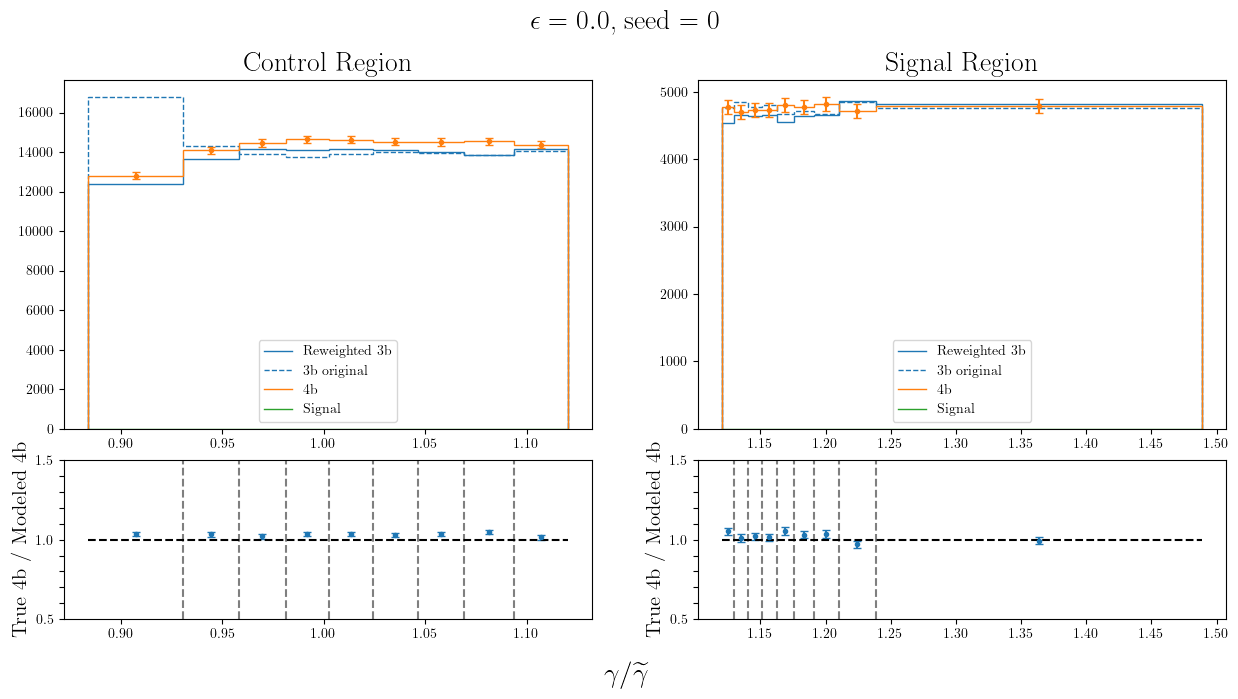

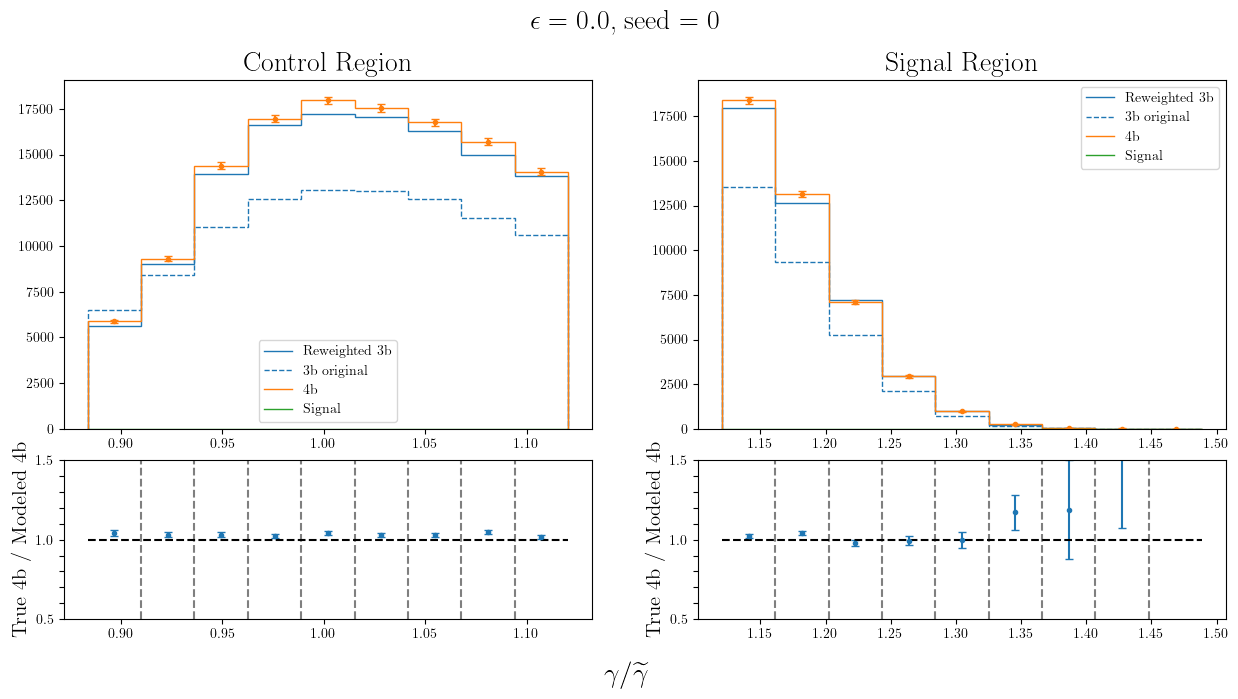

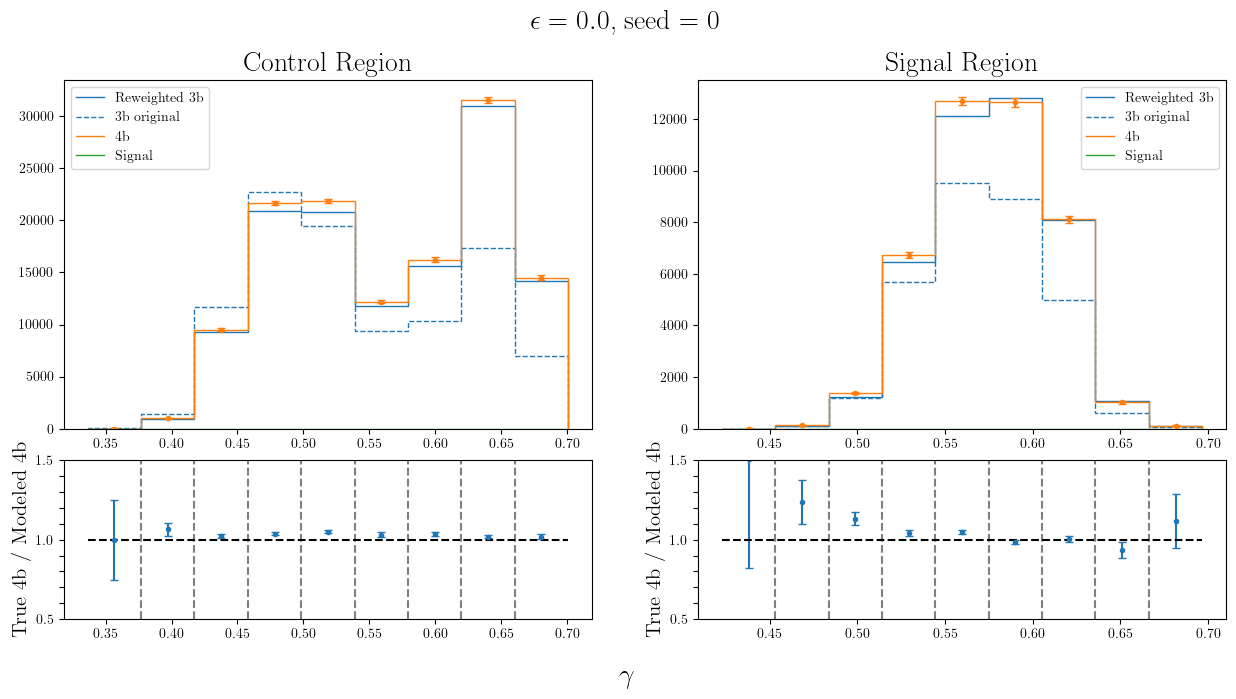

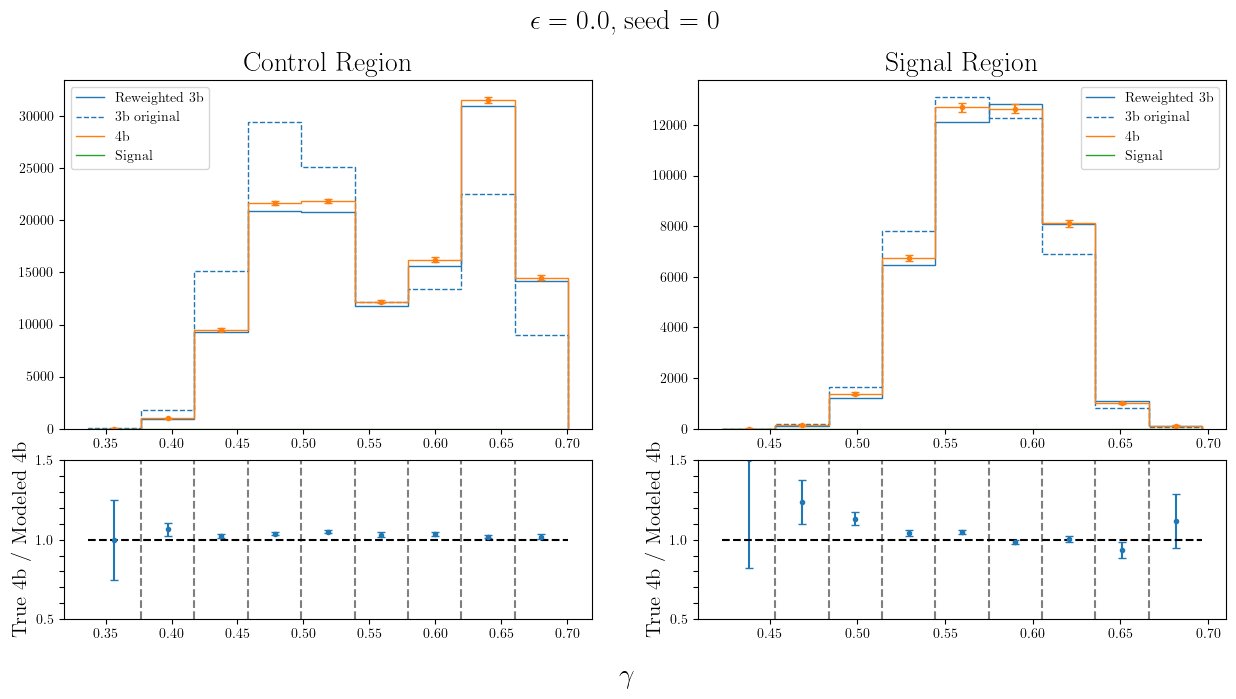

n_3b=1000000, signal_ratio=0.01, seed=0


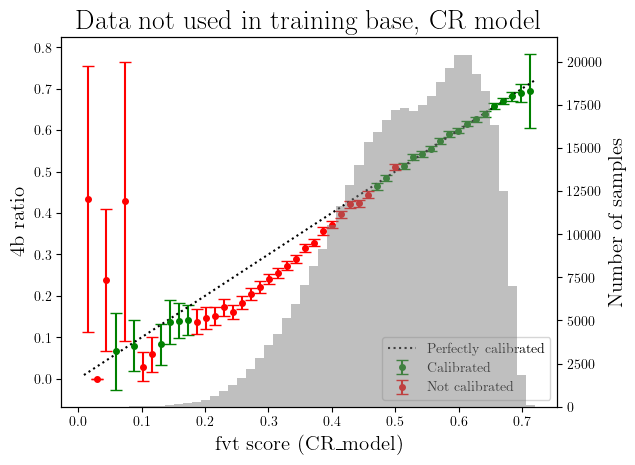

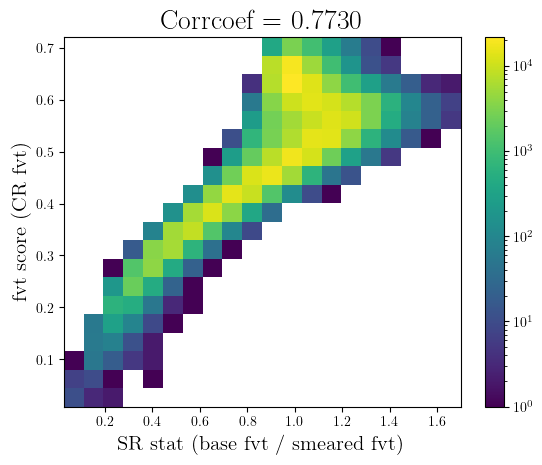

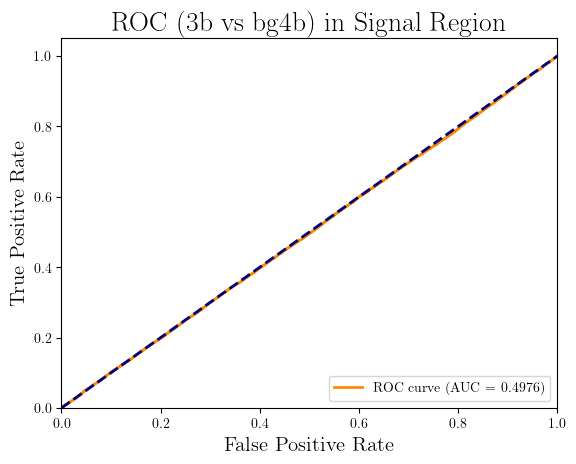

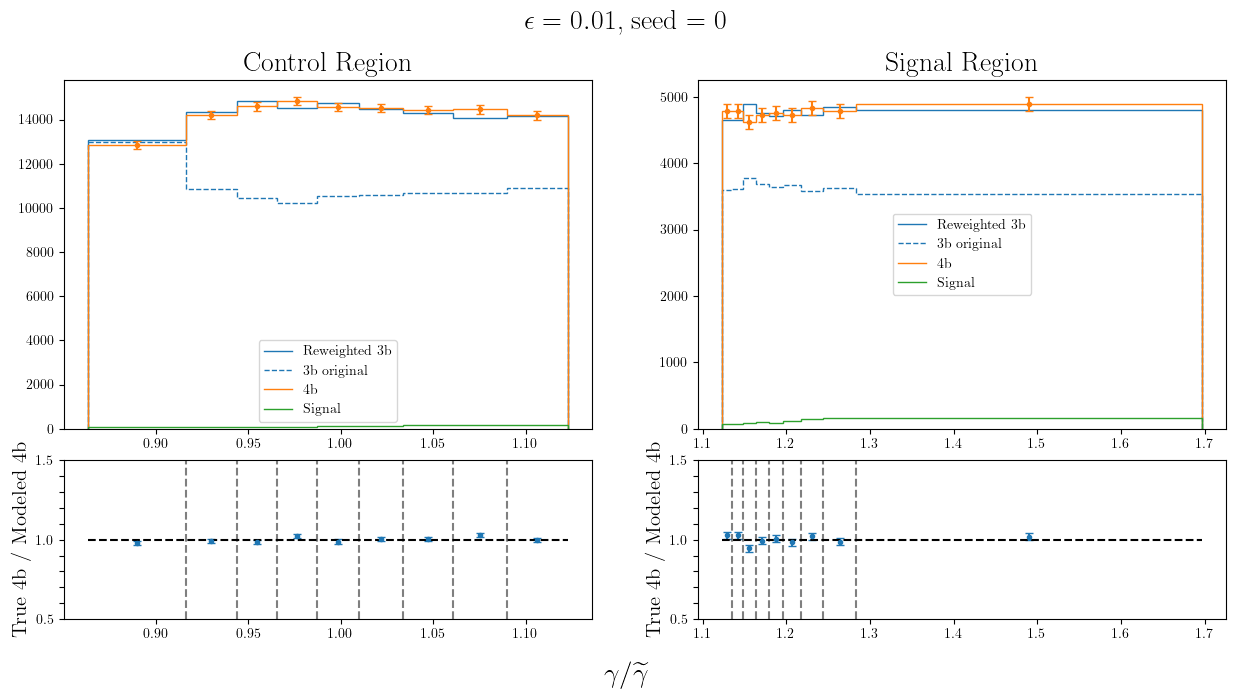

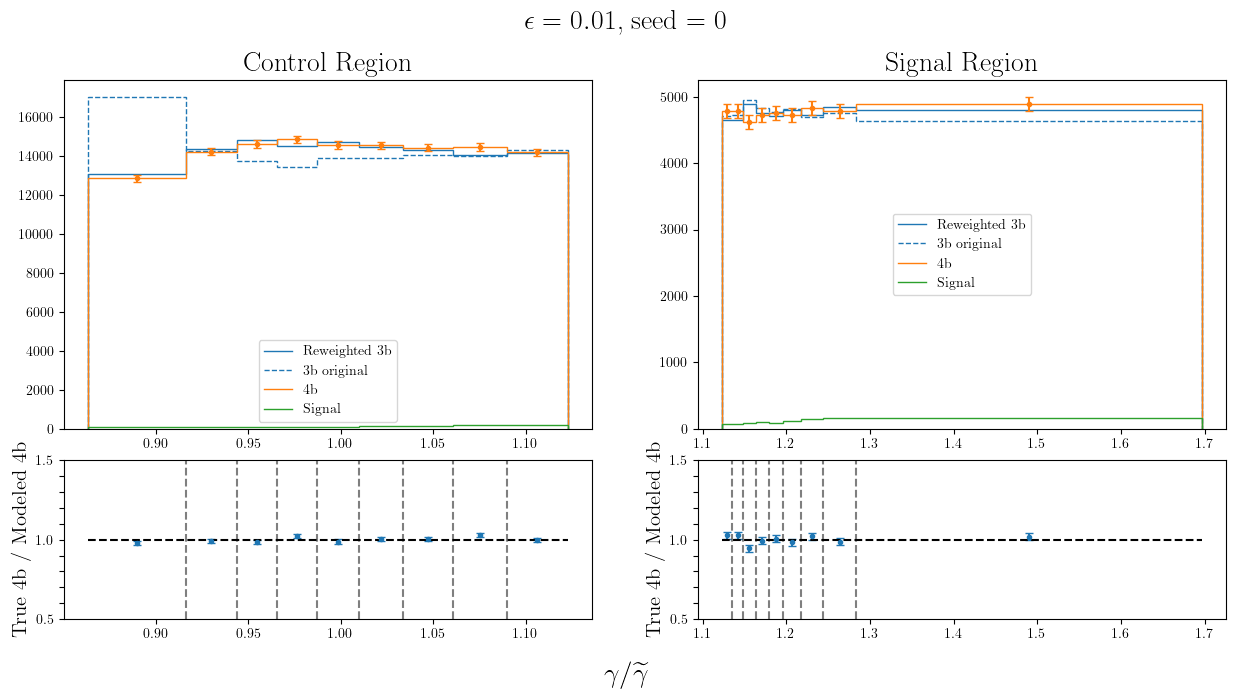

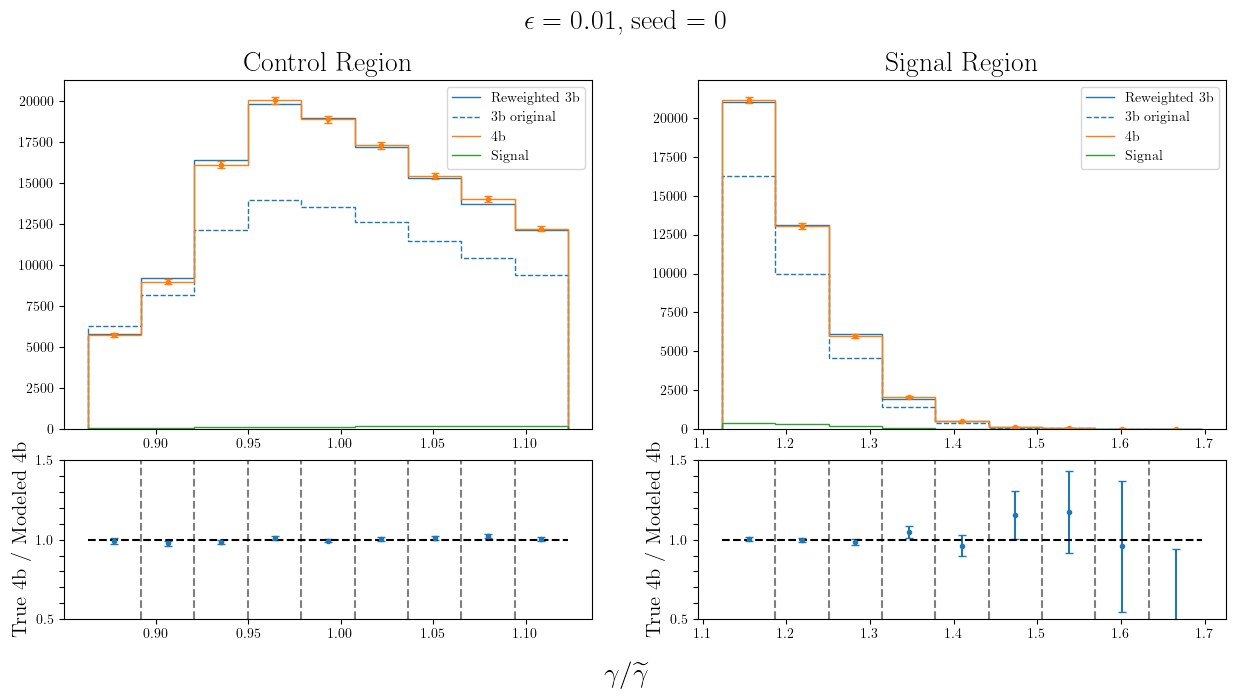

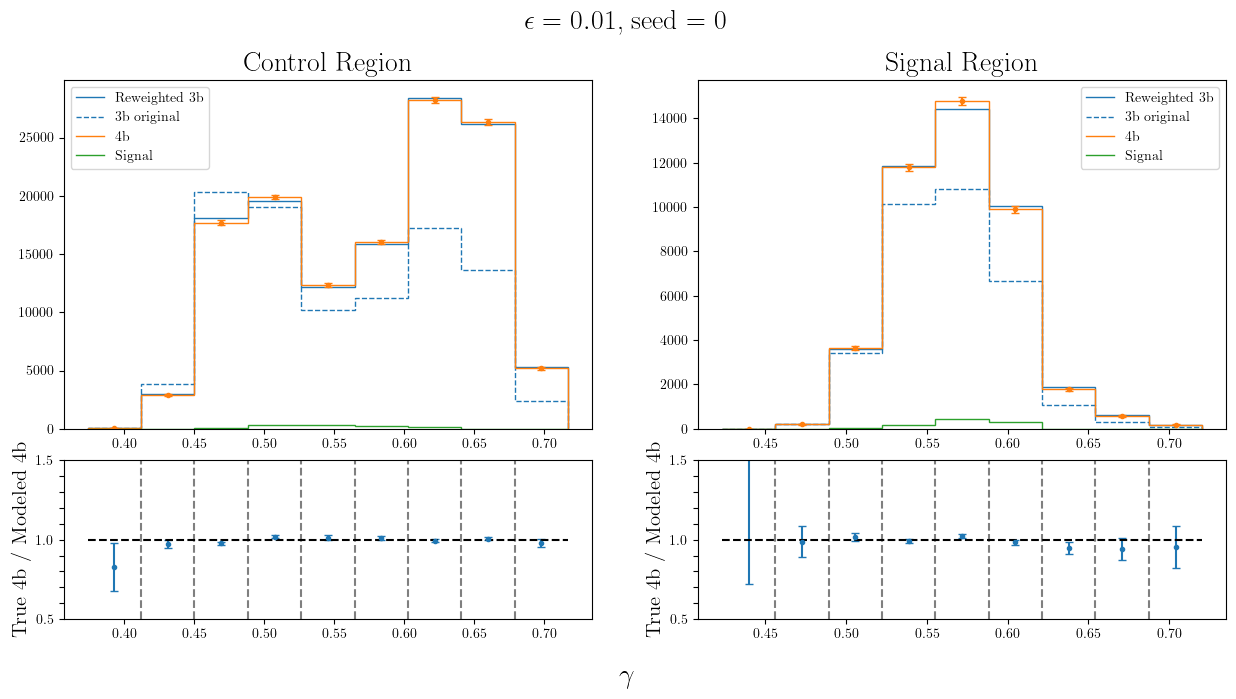

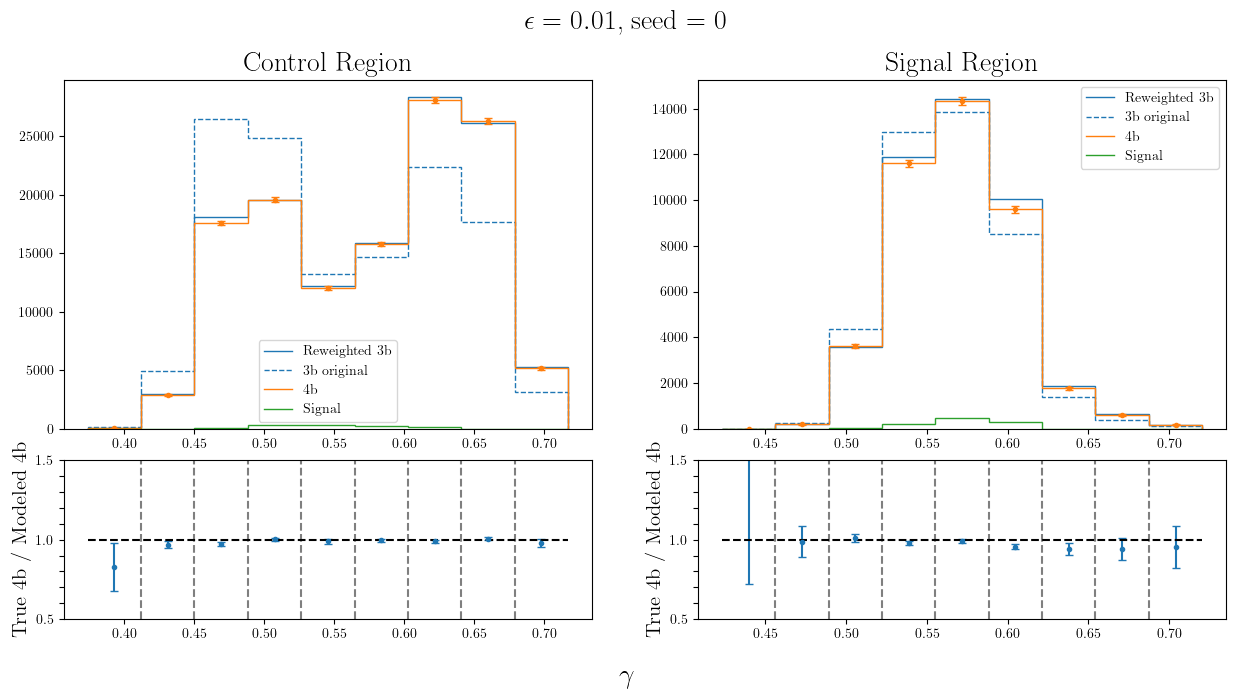

n_3b=1000000, signal_ratio=0.02, seed=0


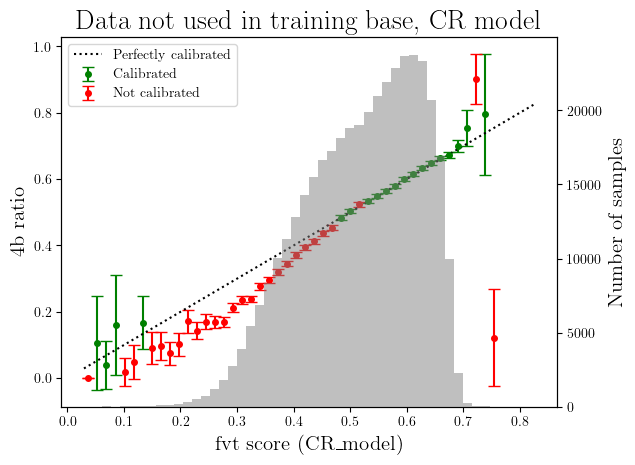

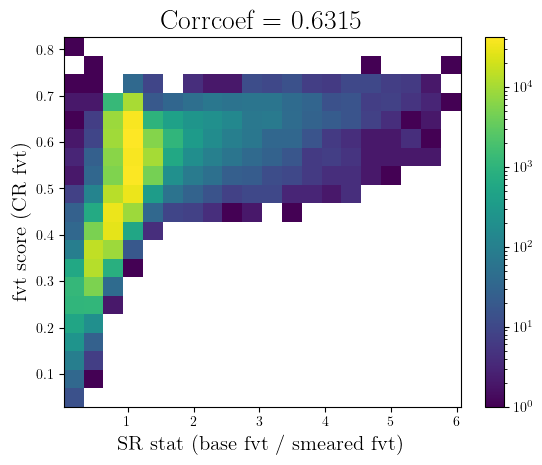

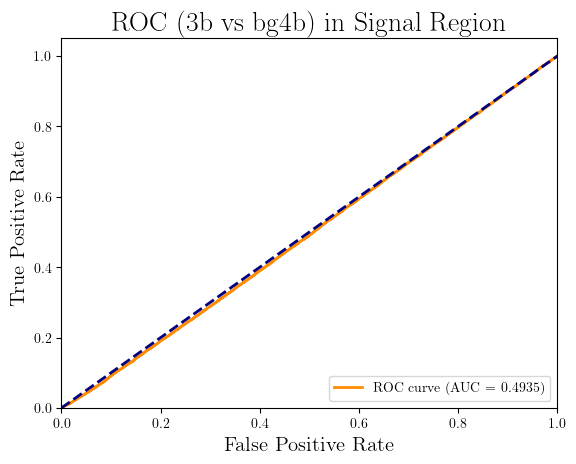

/tmp/ipykernel_1535801/2634567085.py:135: RuntimeWarning: divide by zero encountered in divide
  ax.errorbar((bins_SR[1:] + bins_SR[:-1]) / 2, hist_4b_SR / hist_3b_SR,
/tmp/ipykernel_1535801/2634567085.py:136: RuntimeWarning: divide by zero encountered in divide
  yerr=np.sqrt(hist_4b_SR + hist_3b_sq_SR_original) / hist_3b_SR,
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


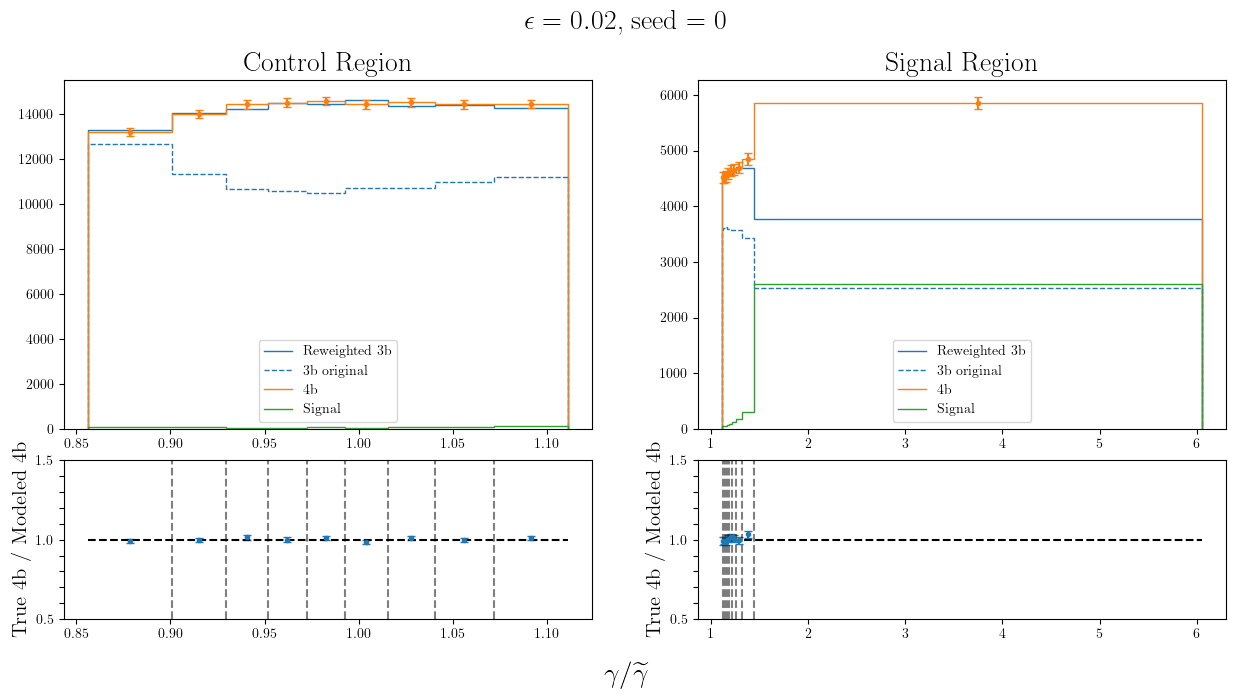

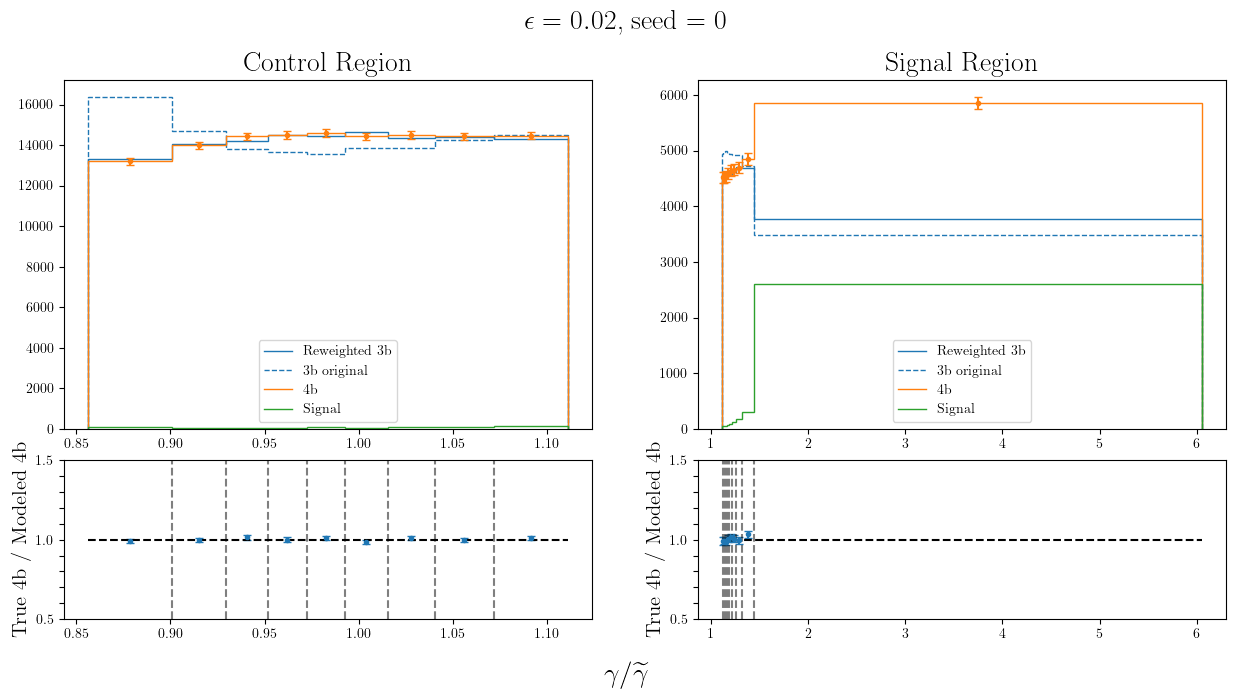

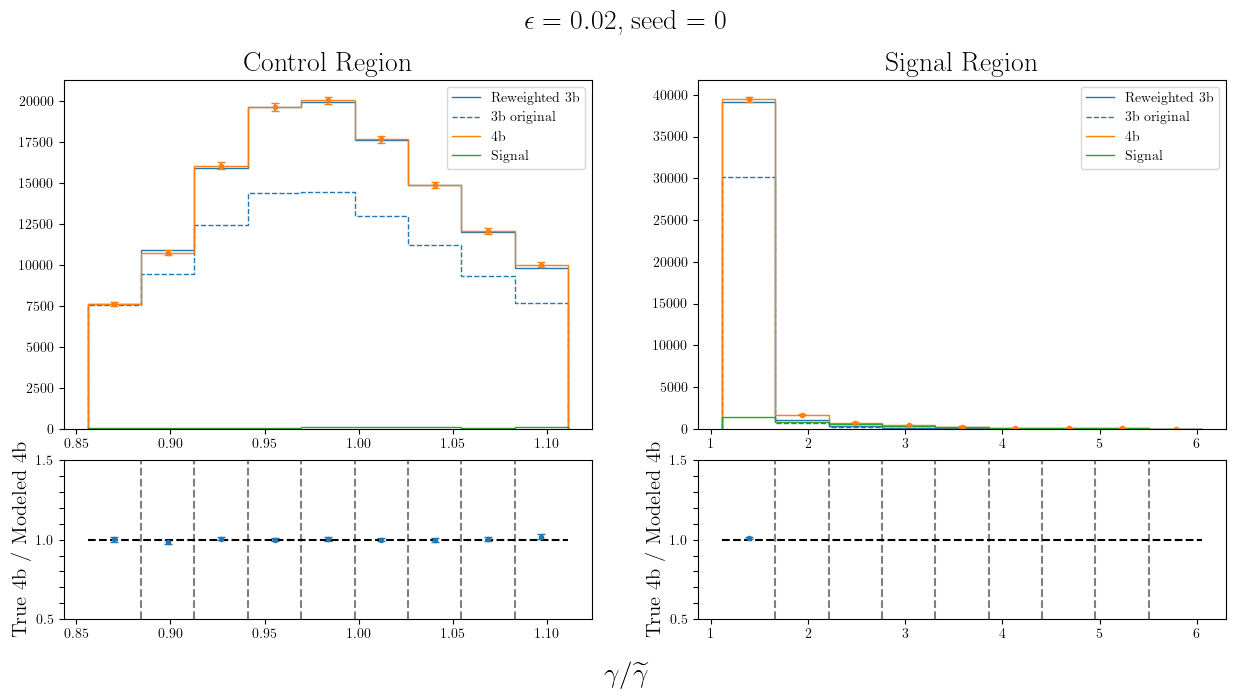

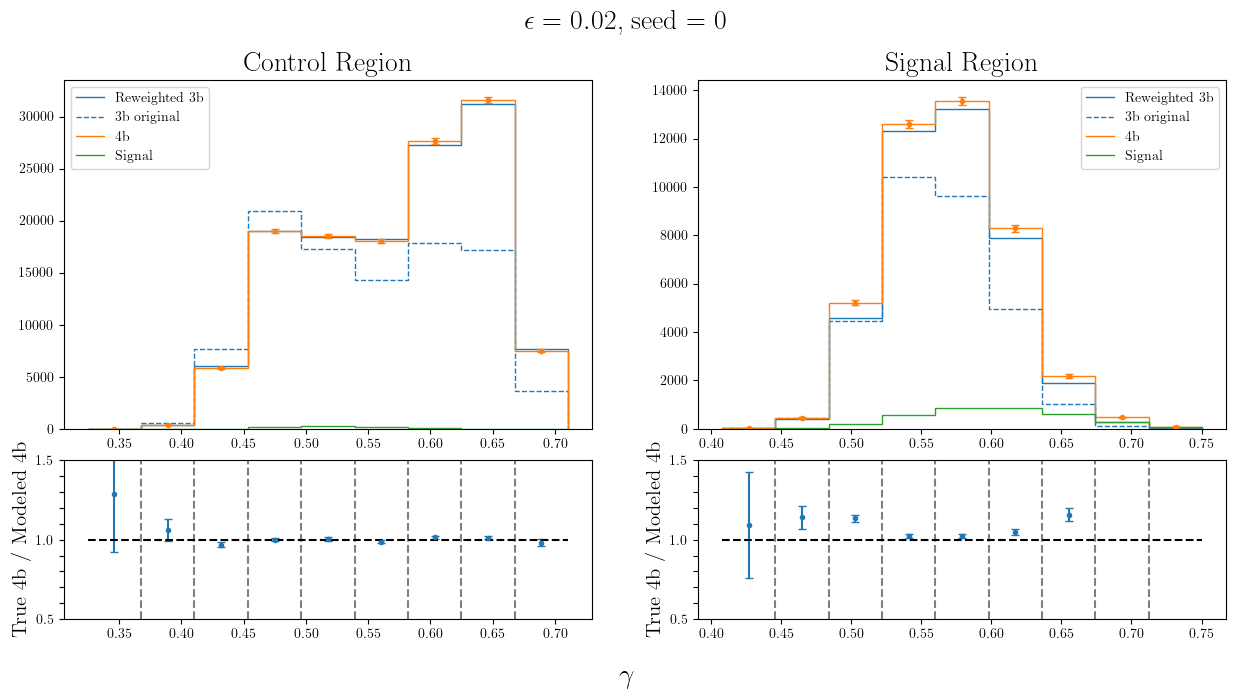

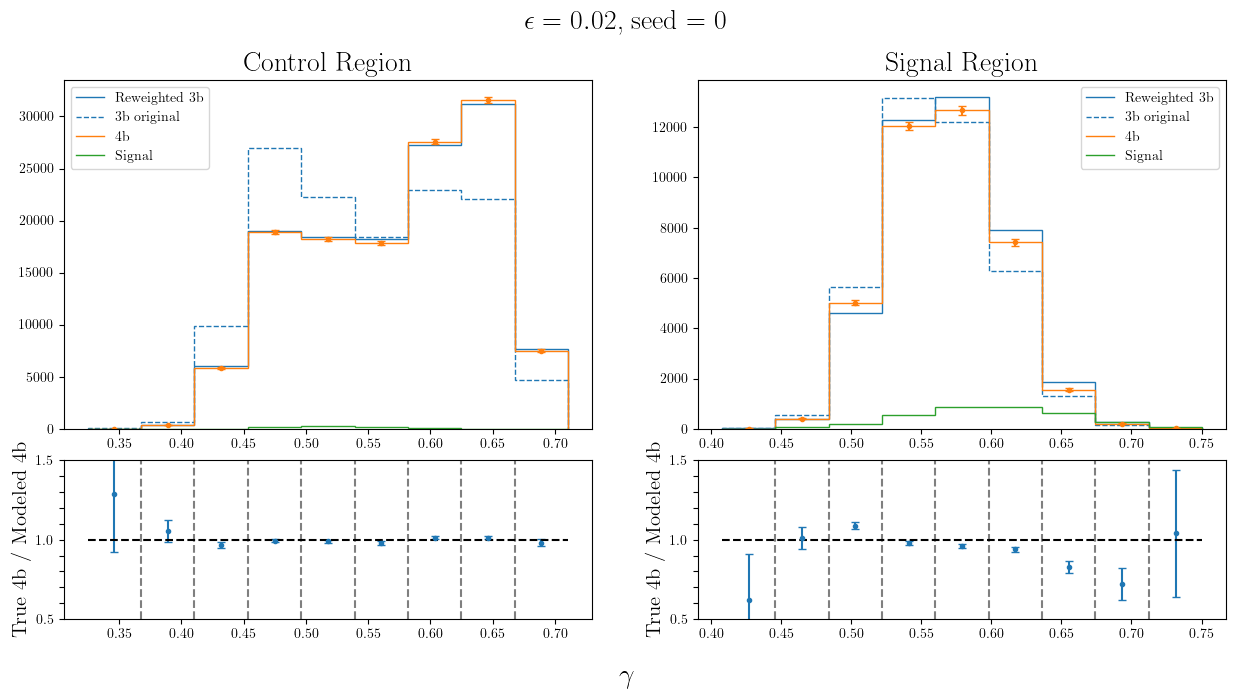

In [6]:
from training_info import TrainingInfoV2
from plots import calibration_plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j

# use tex
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "counting_test_v2"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "n_3b": n_3b,
    "seed": lambda x: x in [0],
}

hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])

for tstinfo_hash in hashes:
    tstinfo = TSTInfo.load(tstinfo_hash)
    print(f"n_3b={tstinfo.hparams['n_3b']}, signal_ratio={tstinfo.hparams['signal_ratio']}, seed={tstinfo.hparams['seed']}")
    CR_fvt_tinfo_hash = tstinfo.CR_fvt_tinfo_hash
    CR_fvt_tinfo = TrainingInfoV2.load(CR_fvt_tinfo_hash)
    CR_model = FvTClassifier.load_from_checkpoint(f"data/checkpoints/{CR_fvt_tinfo.hash}_best.ckpt")
    CR_model.to(device)
    CR_model.eval()
    
    train_scdinfo, val_scdinfo = CR_fvt_tinfo.fetch_train_val_scdinfo()
    events_train = events_from_scdinfo(train_scdinfo, features, signal_filename)
    events_val = events_from_scdinfo(val_scdinfo, features, signal_filename)
    events_tst = events_from_scdinfo(tstinfo.scdinfo_tst, features, signal_filename)
    
    tst_fvt_scores = CR_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
    
    fig, ax = plt.subplots()
    calibration_plot(tst_fvt_scores, events_tst.is_4b, bins=50, sample_weights=events_tst.weights, ax=ax)
    ax.set_xlabel("fvt score (CR_model)")
    ax.set_ylabel("4b ratio")
    ax.set_title("Data not used in training base, CR model")
    plt.show()
    plt.close()
    
    # check correlation between SR stat and fvt score
    SR_stat = tstinfo.SR_stats
    plt.hist2d(SR_stat, tst_fvt_scores, bins=20, norm=LogNorm())
    plt.colorbar()
    plt.title("Data not sued in training base, CR model")
    plt.xlabel("SR stat (base fvt / smeared fvt)")
    plt.ylabel("fvt score (CR fvt)")
    plt.title(f"Corrcoef = {np.corrcoef(SR_stat, tst_fvt_scores)[0, 1]:.4f}")
    plt.show()
    plt.close()
    
    reweights = tst_fvt_scores / (1 - tst_fvt_scores) * (ratio_4b / (1 - ratio_4b))
    SR_cut = tstinfo.SR_cut
    CR_cut = tstinfo.CR_cut
    
    in_SR = SR_stat >= SR_cut
    in_CR = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    
    events_tst_clone = events_tst.clone()
    events_tst_clone.reweight(np.where(events_tst_clone.is_4b, 
                                        events_tst_clone.weights, 
                                        events_tst_clone.weights * reweights))
    bg_in_SR = (~events_tst_clone.is_signal) & in_SR
    fpr, tpr, _ = roc_curve(events_tst_clone.is_4b[bg_in_SR], SR_stat[bg_in_SR], sample_weight=events_tst_clone.weights[bg_in_SR])

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC (3b vs bg4b) in Signal Region')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()
    
    
    
    in_CR = (SR_stat >= CR_cut) & (SR_stat < SR_cut)
    SR_stat_CR = SR_stat[in_CR]
    events_tst_clone_CR = events_tst_clone[in_CR]

    
    plot_hist_and_ratio(tstinfo, SR_stat, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="quantile",
                        nbins=10,
                        xlabel=r"$\gamma / \widetilde{\gamma}$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}")
    plot_hist_and_ratio(tstinfo, SR_stat, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="quantile",
                        nbins=10,
                        xlabel=r"$\gamma / \widetilde{\gamma}$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}",
                        scale_original=True)
    plot_hist_and_ratio(tstinfo, SR_stat, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="uniform",
                        nbins=10,
                        xlabel=r"$\gamma / \widetilde{\gamma}$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}")
    plot_hist_and_ratio(tstinfo, tst_fvt_scores, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="uniform",
                        nbins=10,
                        xlabel=r"$\gamma$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}")
    plot_hist_and_ratio(tstinfo, tst_fvt_scores, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="uniform",
                        nbins=10,
                        xlabel=r"$\gamma$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}", 
                        scale_original=True, do_bg4b=True)
    # plot_hist_and_ratio(tstinfo, events_tst_clone.X[:, 0], events_tst_clone, events_tst, in_CR, in_SR, 
    #                     bins_mode="quantile",
    #                     nbins=10,
    #                     xlabel="jet 0 pt")
    # plot_hist_and_ratio(tstinfo, get_m4j(events_tst_clone.X_torch), events_tst_clone, events_tst, in_CR, in_SR, 
    #                     bins_mode="uniform",
    #                     nbins=10,
    #                     xlabel="m_4j", 
    #                     yscale="log")
    
    plt.show()
    plt.close()


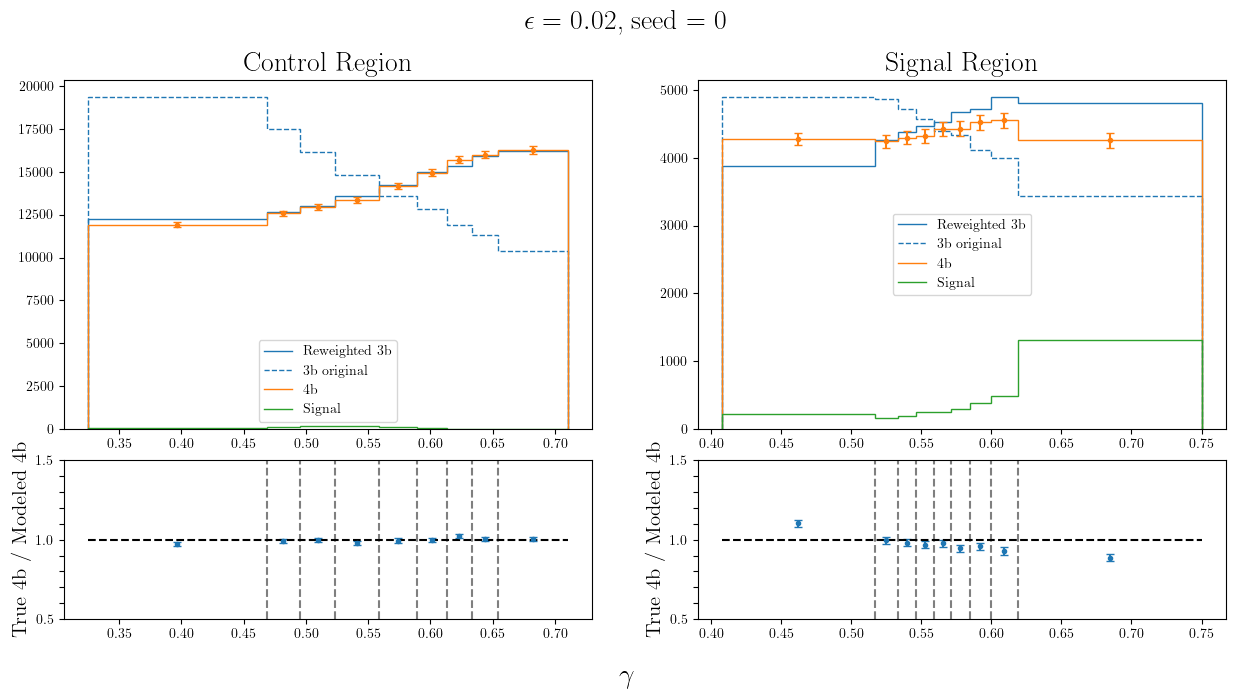

In [7]:
plot_hist_and_ratio(tstinfo, tst_fvt_scores, events_tst_clone, events_tst, in_CR, in_SR, 
                        bins_mode="quantile",
                        nbins=10,
                        xlabel=r"$\gamma$", 
                        title=rf"$\epsilon = {tstinfo.hparams['signal_ratio']}$, seed = {tstinfo.hparams['seed']}", 
                        do_bg4b=True, scale_original=True)